# Project_10 - Regression (Taxi)

### Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project Workflow

1. Download the data and resample it by one hour.
2. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
3. Test the data using the test sample and provide a conclusion.

## Preparation

In [2]:
#import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose

In [9]:
#load the data
df_original = pd.read_csv('datasets/project_08_dataset.csv', index_col=[0], parse_dates=[0])
df_original.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


#df_original.to_csv('~/work/project_datasets/project_08_dataset.csv', index=False, header=list(df_original.columns))

In [10]:
#Resample it by one hour
df_original.sort_index(inplace=True)
df = df_original.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
#create features
def make_features(data):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dow'] = data.index.dayofweek
    data['hour'] = data.index.hour
    data['orders_lag1'] = data['num_orders'].shift(1)
    data['orders_lag2'] = data['num_orders'].shift(2)
    data['num_orders_next'] = data['num_orders'].shift(periods=-1)

In [8]:
make_features(df)
display(df.head(10))
display(df.info())

,num_orders,year,month,day,dow,hour,orders_lag1,orders_lag2,num_orders_next
datetime,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,85.0
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,71.0
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,66.0
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,43.0
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,6.0
2018-03-01 05:00:00,6,2018,3,1,3,5,43.0,66.0,12.0
2018-03-01 06:00:00,12,2018,3,1,3,6,6.0,43.0,15.0
2018-03-01 07:00:00,15,2018,3,1,3,7,12.0,6.0,34.0
2018-03-01 08:00:00,34,2018,3,1,3,8,15.0,12.0,69.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_orders       4416 non-null   int64  
 1   year             4416 non-null   int64  
 2   month            4416 non-null   int64  
 3   day              4416 non-null   int64  
 4   dow              4416 non-null   int64  
 5   hour             4416 non-null   int64  
 6   orders_lag1      4415 non-null   float64
 7   orders_lag2      4414 non-null   float64
 8   num_orders_next  4415 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 345.0 KB


None

## Analysis

<AxesSubplot:xlabel='datetime'>

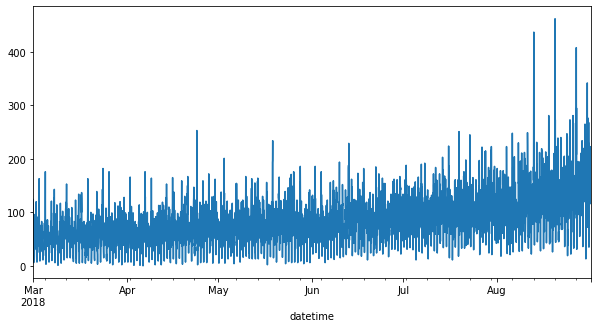

In [5]:
plt.figure(figsize=(10, 5))
df['num_orders'].plot()

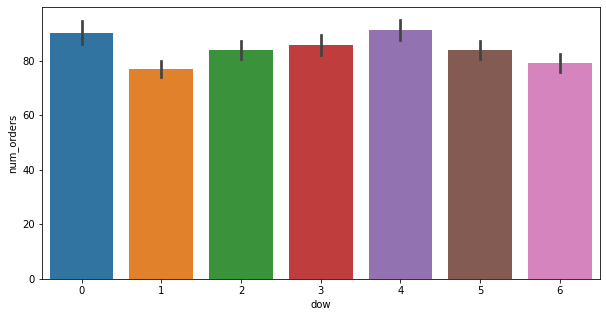

In [6]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='dow', y='num_orders')
plt.show()

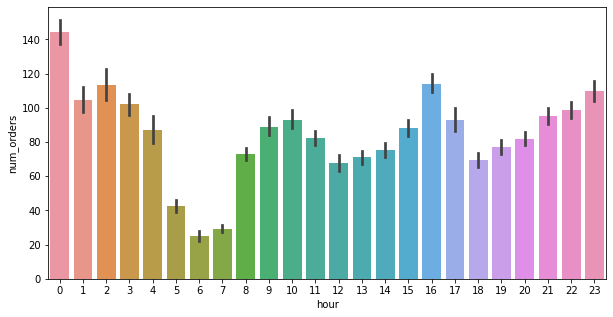

In [7]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df, x='hour', y='num_orders')
plt.show()

<AxesSubplot:xlabel='dow', ylabel='hour'>

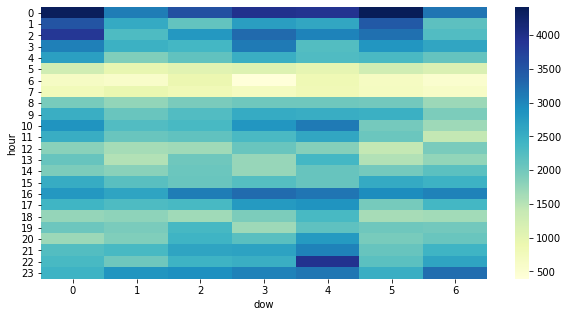

In [8]:
plt.figure(figsize=(10, 5))
df_agg = df.groupby(['dow', 'hour'])['num_orders'].sum().reset_index()
heatmap_data = df_agg.pivot('hour', 'dow', 'num_orders')
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar=True)

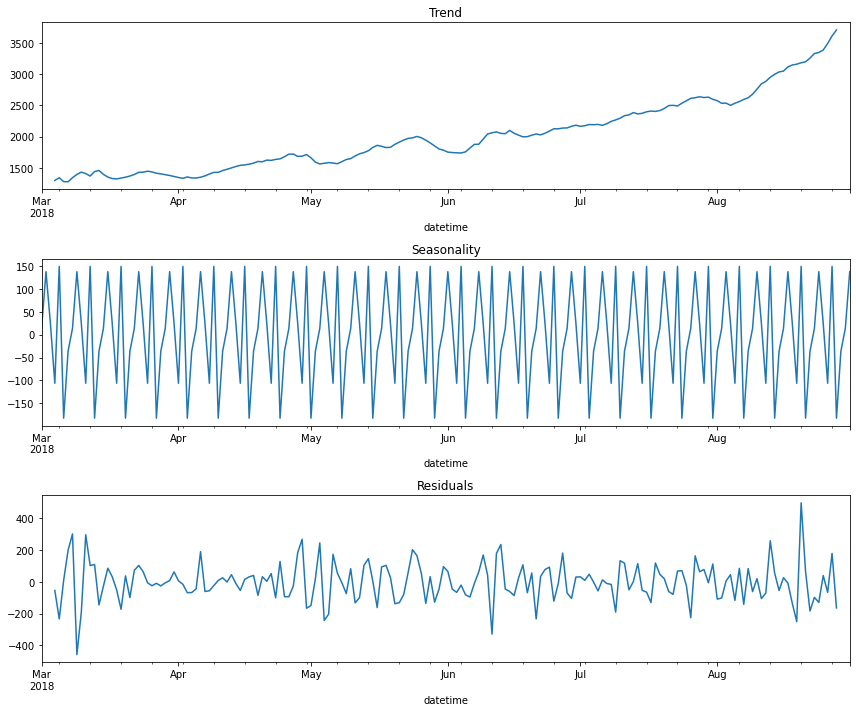

In [15]:
df_day = df.resample('1D').sum()
decomposed = seasonal_decompose(df_day['num_orders'])

plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

<div class="alert btn-primary"><b>Student comment:</b><br>      </div>
<br>The day of the week seems to have moderate affect on the number of orders, with Sunday and Thursday having the highest number of orders.
<br>The hour of day seems to have sigfnificant affect on the number of orders, with 5-7am having the lowest number of orders.

## Training & Testing

In [10]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()
X_train = train.drop(['num_orders', 'num_orders_next'], axis=1)
y_train = train['num_orders_next']
X_test = test.drop(['num_orders', 'num_orders_next'], axis=1)
y_test = test['num_orders_next']

In [11]:
#using the current hour's order quantity to predict the next hour
y_pred = y_test.shift(fill_value=y_train.iloc[-1]).values
print("RMSE:", MSE(y_test, y_pred, squared=False))

RMSE: 58.91761802963282


In [12]:
#train and evaluate linear regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)

#print("RMSE lr_train:", MSE(y_train, y_pred_train, squared=False))
print("RMSE lr_test: ", MSE(y_test, y_pred_test, squared=False))

RMSE lr_test:  59.10144333246986


In [13]:
#train and evaluate random forest regression model
rfr = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {'max_depth':[5, 7], 'n_estimators':[50, 100]}
gscv = GridSearchCV(rfr, param_grid=param_grid, cv=tscv)
gscv.fit(X_train, y_train)
rfr_model = gscv.best_estimator_
display(f'Best Params: {gscv.best_params_}')

y_pred_train = rfr_model.predict(X_train)
y_pred_test = rfr_model.predict(X_test)

#print("RMSE rfr_train:", MSE(y_train, y_pred_train, squared=False))
print("RMSE rfr_test: ", MSE(y_test, y_pred_test, squared=False))

"Best Params: {'max_depth': 7, 'n_estimators': 50}"

RMSE rfr_test:  51.449576745866786


In [14]:
#train and evaluate lightgbm regression model
train_data = lgb.Dataset(X_train, label=y_train)
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'feature_fraction': 0.7
}

num_round = 100
bst = lgb.train(params, train_data, num_round)
y_pred_train = bst.predict(X_train, num_iteration=bst.best_iteration)
y_pred_test = bst.predict(X_test, num_iteration=bst.best_iteration)

#print("RMSE gbm_train:", MSE(y_train, y_pred_train, squared=False))
print("RMSE gbm_test: ", MSE(y_test, y_pred_test, squared=False))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 450
[LightGBM] [Info] Number of data points in the train set: 3972, number of used features: 6
[LightGBM] [Info] Start training from score 78.285247
RMSE gbm_test:  42.16013482919463


<br>-The goal the project is to predict the taxi orders for the next hour, so I used y_train.shift(periods=-1) as the target value, and did the same for the test set.
<br>-This way, we could use the current date, time, and order amounts to predict the amount of taxi orders for the next hour.
<br>-The light gbm regression model performed the best out of all the models, with a RMSE of 42.16.
<br>-This dataset only contains 6 months worth of data, which means we don't know how the taxi orders will change in the other 6 months of the year. Also, the business seemed to have been growing steadily during this time, which makes it even harder to provide a good prediction for the other months. It would be great to have at least 3-5 years of data to account for the seasonality of the taxi orders.
<br>-Added the lag features, but skipped rolling mean feature as it didn't improve the final score.
<br>-Added seasonal decomposition to see the overall trend and seasonlity of the data.

# Checklist

- [x]  The code is error-free
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48